In [1]:
# Standard Libraries
import os # operating system dependent functionality
from collections import Counter # counting elements in an iterable

# External Libraries
import numpy as np # numerical operations on data arrays and matrices
import pandas as pd # data manipulation and analysis
import matplotlib.pyplot as plt # plotting and visualizations
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors

# Bioinformatics and Data Analysis 
import anndata # handling annotated data, particularly in genomics
import scanpy as sc # single-cell RNA-seq data analysis
import scipy # scientific and technical computations

In [2]:
import ot 

# Load human and mouse processed and homolog intersected data

In [3]:
# human cells: 1900 cells
human_restricted = anndata.read_h5ad("/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_homolog_intersected_data/human_pancreas_one_sample_preprocessed_homolog_intersected_adata.h5ad")
# mice cells: 1886 cells 
mouse_restricted = anndata.read_h5ad("/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_homolog_intersected_data/mouse_pancreas_preprocessed_homolog_intersected_adata.h5ad")

In [4]:
human_restricted

AnnData object with n_obs × n_vars = 1937 × 12113
    obs: 'cell_barcodes', 'cell_manual_ids', 'cell_types', 'batch_sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_name', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'ensembl_id'

In [5]:
mouse_restricted

AnnData object with n_obs × n_vars = 1886 × 12113
    obs: 'cell_barcodes', 'cell_manual_ids', 'cell_types', 'batch_sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_name', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'ensembl_id'

In [6]:
human_restricted.X = human_restricted.X.toarray()
mouse_restricted.X = mouse_restricted.X.toarray()

# Finding Nearest Neighbors

### Method 2) Optimal Transport

In [27]:
def optimal_transport_pairing(adata_human, adata_mouse):
    """
    Compute the optimal transport (OT) pairing between human and mouse cells.

    Parameters:
    - adata_human: AnnData object for human cells.
    - adata_mouse: AnnData object for mouse cells.

    Returns:
    - paired_indices: List of tuples (human_index, mouse_index) of paired cells.
    """
    # Extract the gene expression matrices
    X_human = adata_human.X
    X_mouse = adata_mouse.X
    
    # Compute the cost matrix using Euclidean distance
    cost_matrix = ot.dist(X_human, X_mouse, metric='euclidean')

    # Visualize the cost matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(cost_matrix, aspect='auto', cmap='viridis')
    plt.colorbar(label='Euclidean Distance')
    plt.title('Cost Matrix (Euclidean Distance)')
    plt.xlabel('Mouse Cells')
    plt.ylabel('Human Cells')
    plt.show()
    
    # Uniform distribution over human and mouse cells
    human_distribution = np.ones(X_human.shape[0]) / X_human.shape[0]
    mouse_distribution = np.ones(X_mouse.shape[0]) / X_mouse.shape[0]
    
    # Compute the optimal transport matrix using the Earth Mover's Distance
    ot_matrix = ot.emd(human_distribution, mouse_distribution, cost_matrix)
    
    # Find the optimal pairs based on the transport plan
    paired_indices = []
    for human_idx in range(ot_matrix.shape[0]):
        mouse_idx = np.argmax(ot_matrix[human_idx])
        paired_indices.append((human_idx, mouse_idx))
    
    return paired_indices, ot_matrix

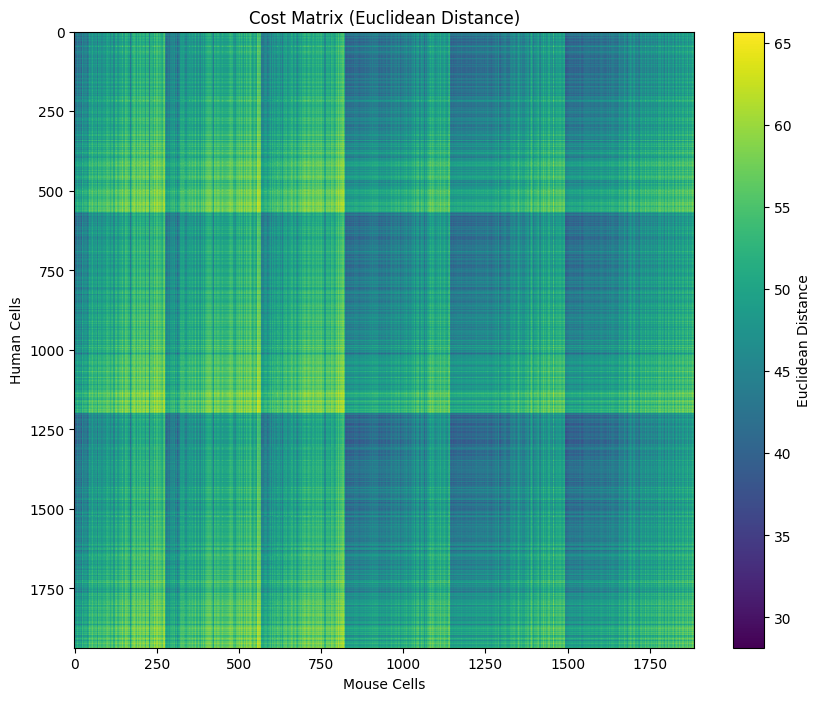

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/ot/lp/__init__.py:361: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


1937

In [28]:
paired_indices, ot_matrix = optimal_transport_pairing(human_restricted, mouse_restricted)
len(paired_indices)

In [9]:
print(paired_indices[0])
print(paired_indices[1])
print(paired_indices[2])

(0, 592)
(1, 357)
(2, 226)


In [10]:
human_mouse_adata = anndata.read_h5ad("/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_homolog_intersected_data/human_mouse_preprocessed_joint_adata.h5ad")
human_mouse_adata

AnnData object with n_obs × n_vars = 3823 × 12113
    obs: 'cell_barcodes', 'cell_manual_ids', 'cell_types', 'batch_sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'species_cell_type_label', 'species_label'
    var: 'homolog_pair_idx', 'human_gene_name', 'mouse_gene_name', 'human_gene_ensembl_id', 'mouse_gene_ensembl_id'
    uns: 'cell_types_colors', 'neighbors', 'pca', 'species_label_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [11]:
def plot_joint_umap_with_pairs(
    human_mouse_joint_adata,
    num_human_cells,
    paired_indices,
    color_label,
    save_path,
    cell_type=None,
    adata_human=None,
    adata_mouse=None,
    filter_by_human=True  # if True, shows which mouse cells all human cells map to, else vice versa
):
    """
    Create a joint UMAP of human and mouse AnnData objects and plot the lines connecting paired cells.

    Parameters:
    - human_mouse_adata: AnnData object for human and mouse cells.
    - paired_indices: List of tuples (human_index, mouse_index) of paired cells.
    """
    # Add species labels to the obs attributes for coloring
    # adata_human.obs['species'] = 'human'
    # adata_mouse.obs['species'] = 'mouse'
    
    # # Concatenate the two AnnData objects
    # adata_combined = adata_human.concatenate(adata_mouse)
    
    # # Compute UMAP on the combined data
    # sc.pp.neighbors(adata_combined)
    # sc.tl.umap(adata_combined)
    
    # Plot the UMAP
    sc.pl.umap(
        human_mouse_joint_adata, 
        color=color_label, 
        show=False, 
        size=12,
        title="Human & Mouse Pancreas Joint UMAP\nHomologous Gene Feature Space",
    )

    # Extract the UMAP coordinates
    umap_human = human_mouse_joint_adata.obsm['X_umap'][:num_human_cells, :]
    umap_mouse = human_mouse_joint_adata.obsm['X_umap'][num_human_cells:, :]

    # Filter the paired indices based on the specified cell type, if provided
    if cell_type:
        if filter_by_human:
            human_cell_type_mask = adata_human.obs['cell_types'] == cell_type
            filtered_pairs = [
                (human_idx, mouse_idx) for human_idx, mouse_idx in paired_indices
                if human_cell_type_mask[human_idx]
            ]
        else:
            mouse_cell_type_mask = adata_mouse.obs['cell_types'] == cell_type
            filtered_pairs = [
                (human_idx, mouse_idx) for human_idx, mouse_idx in paired_indices
                if mouse_cell_type_mask[mouse_idx]
            ]
    else:
        # Use all pairs if no cell type is specified
        filtered_pairs = paired_indices

    # Plot lines connecting paired human and mouse cells
    for human_idx, mouse_idx in filtered_pairs:
        # Get the UMAP coordinates of the paired human and mouse cells
        human_coord = umap_human[human_idx]
        mouse_coord = umap_mouse[mouse_idx]
        
        # Plot a light gray line connecting the paired cells
        plt.plot([human_coord[0], mouse_coord[0]], 
                 [human_coord[1], mouse_coord[1]], 
                 color='lightgray', linewidth=0.5, alpha=0.2, linestyle="--")

    plt.savefig(save_path, facecolor="white", bbox_inches="tight", dpi=300)
    plt.show()
    plt.close()

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


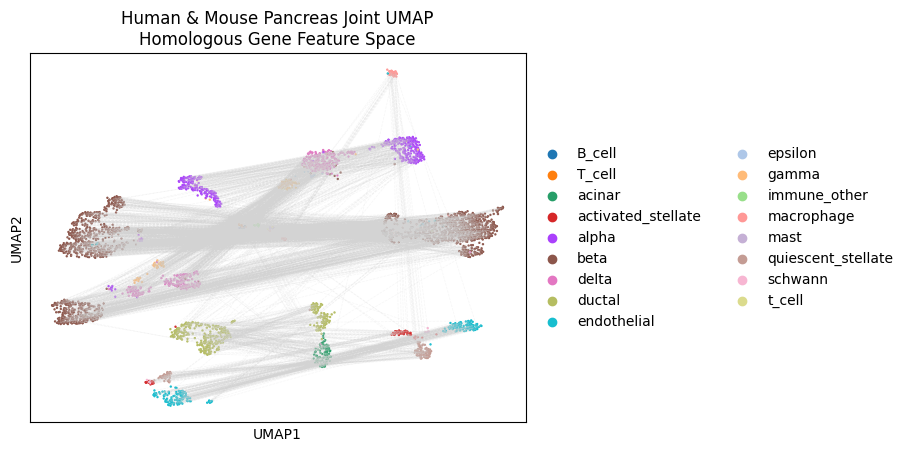

In [12]:
plot_joint_umap_with_pairs(
    human_mouse_joint_adata=human_mouse_adata, 
    num_human_cells=human_restricted.shape[0],
    paired_indices=paired_indices,
    color_label="cell_types",  # species_label, cell_types
    save_path="/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_homolog_intersected_data/human_mouse_joint_umap_with_ot_pair_paths_color_cell_types.png",
    cell_type=None,
)

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


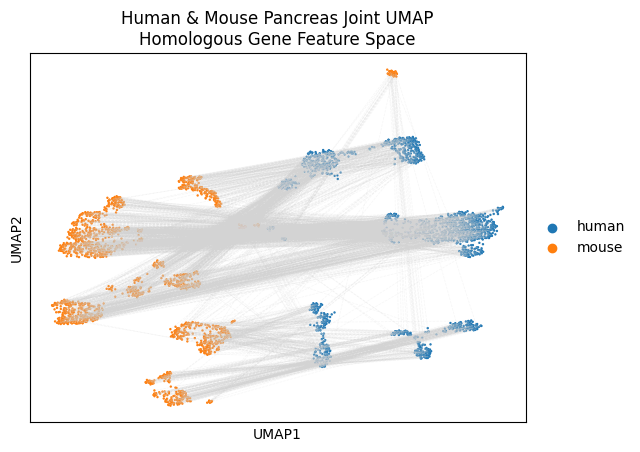

In [13]:
plot_joint_umap_with_pairs(
    human_mouse_joint_adata=human_mouse_adata, 
    num_human_cells=human_restricted.shape[0], 
    paired_indices=paired_indices,
    color_label="species_label",  # species_label, cell_types
    save_path="/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_homolog_intersected_data/human_mouse_joint_umap_with_ot_pair_paths_color_species.png",
)

## Coloring OT pairing by cell type

In [14]:
human_to_mouse = True
human_to_mouse_str = "human_to_mouse" if human_to_mouse else "mouse_to_human"
print(human_to_mouse_str)

human_to_mouse


/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


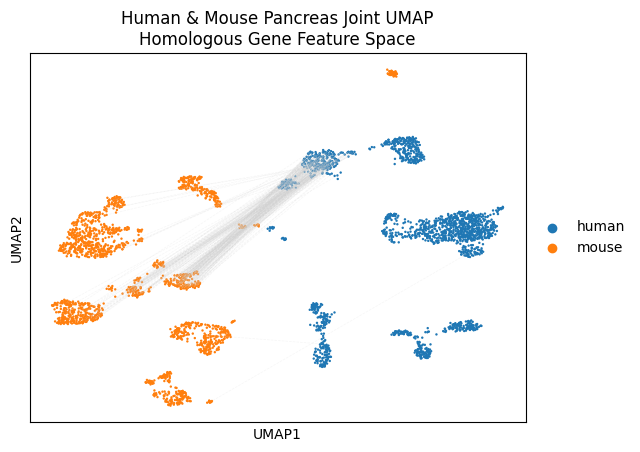

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


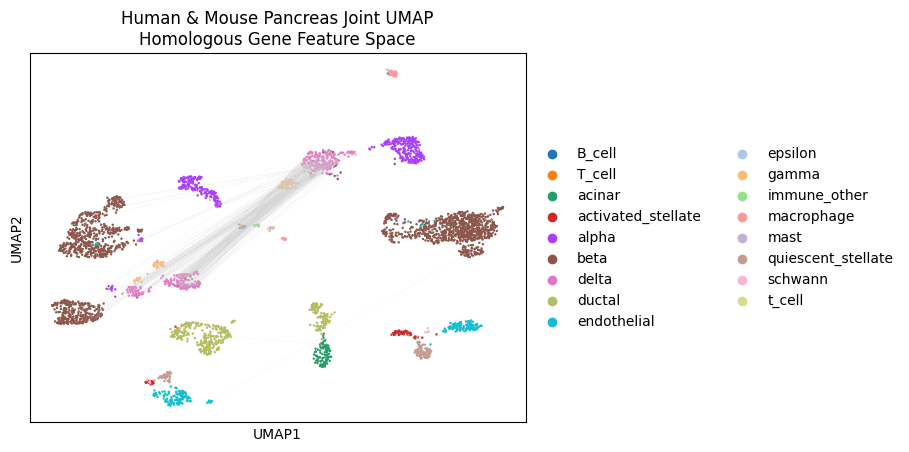

In [15]:
cell_type_label = "delta"
plot_joint_umap_with_pairs(
    human_mouse_joint_adata=human_mouse_adata, 
    num_human_cells=human_restricted.shape[0], 
    paired_indices=paired_indices,
    color_label="species_label",  # species_label, cell_types
    save_path=f"/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_homolog_intersected_data/human_mouse_joint_umap_with_ot_pair_paths_color_species_{cell_type_label}_{human_to_mouse_str}.png",
    cell_type=cell_type_label,
    adata_human=human_restricted,
    adata_mouse=mouse_restricted,
    filter_by_human=human_to_mouse
)
plot_joint_umap_with_pairs(
    human_mouse_joint_adata=human_mouse_adata, 
    num_human_cells=human_restricted.shape[0], 
    paired_indices=paired_indices,
    color_label="cell_types",  # species_label, cell_types
    save_path=f"/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_homolog_intersected_data/human_mouse_joint_umap_with_ot_pair_paths_color_cell_type_{cell_type_label}_{human_to_mouse_str}.png",
    cell_type=cell_type_label,
    adata_human=human_restricted,
    adata_mouse=mouse_restricted,
    filter_by_human=human_to_mouse
)

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


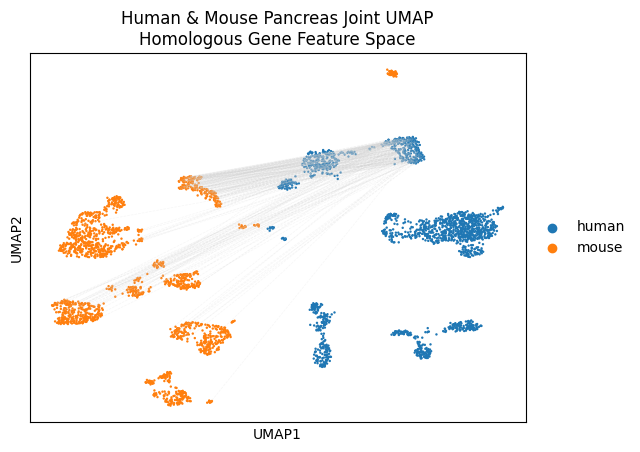

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


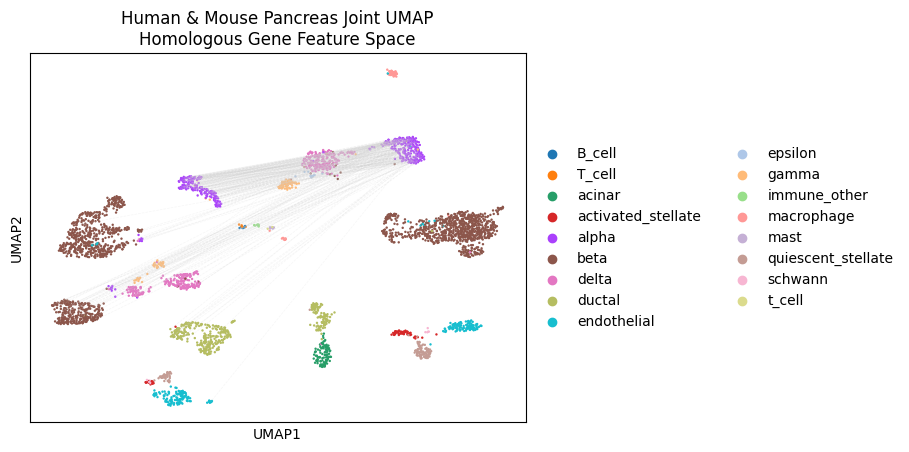

In [16]:
cell_type_label = "alpha"
plot_joint_umap_with_pairs(
    human_mouse_joint_adata=human_mouse_adata, 
    num_human_cells=human_restricted.shape[0], 
    paired_indices=paired_indices,
    color_label="species_label",  # species_label, cell_types
    save_path=f"/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_homolog_intersected_data/human_mouse_joint_umap_with_ot_pair_paths_color_species_{cell_type_label}_{human_to_mouse_str}.png",
    cell_type=cell_type_label,
    adata_human=human_restricted,
    adata_mouse=mouse_restricted,
    filter_by_human=human_to_mouse
)
plot_joint_umap_with_pairs(
    human_mouse_joint_adata=human_mouse_adata, 
    num_human_cells=human_restricted.shape[0], 
    paired_indices=paired_indices,
    color_label="cell_types",  # species_label, cell_types
    save_path=f"/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_homolog_intersected_data/human_mouse_joint_umap_with_ot_pair_paths_color_cell_type_{cell_type_label}_{human_to_mouse_str}.png",
    cell_type=cell_type_label,
    adata_human=human_restricted,
    adata_mouse=mouse_restricted,
    filter_by_human=human_to_mouse
)

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


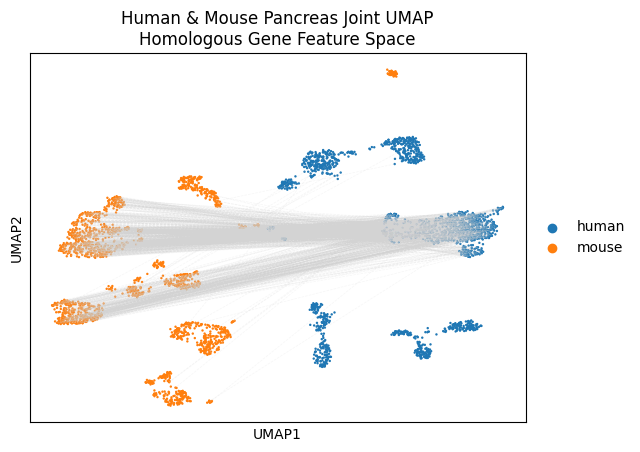

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


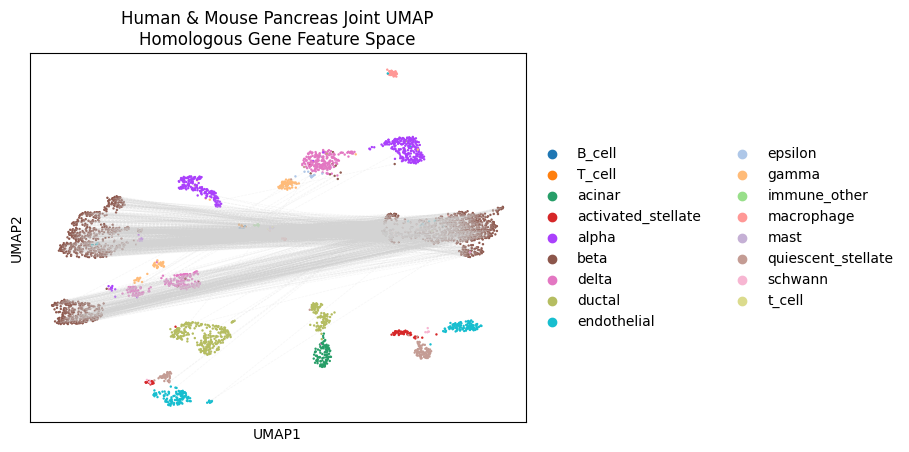

In [17]:
cell_type_label = "beta"
plot_joint_umap_with_pairs(
    human_mouse_joint_adata=human_mouse_adata, 
    num_human_cells=human_restricted.shape[0], 
    paired_indices=paired_indices,
    color_label="species_label",  # species_label, cell_types
    save_path=f"/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_homolog_intersected_data/human_mouse_joint_umap_with_ot_pair_paths_color_species_{cell_type_label}_{human_to_mouse_str}.png",
    cell_type=cell_type_label,
    adata_human=human_restricted,
    adata_mouse=mouse_restricted,
    filter_by_human=human_to_mouse
)
plot_joint_umap_with_pairs(
    human_mouse_joint_adata=human_mouse_adata, 
    num_human_cells=human_restricted.shape[0], 
    paired_indices=paired_indices,
    color_label="cell_types",  # species_label, cell_types
    save_path=f"/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_homolog_intersected_data/human_mouse_joint_umap_with_ot_pair_paths_color_cell_type_{cell_type_label}_{human_to_mouse_str}.png",
    cell_type=cell_type_label,
    adata_human=human_restricted,
    adata_mouse=mouse_restricted,
    filter_by_human=human_to_mouse
)

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


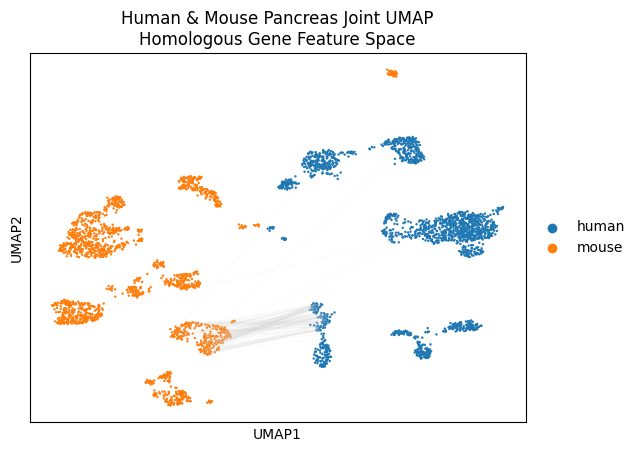

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


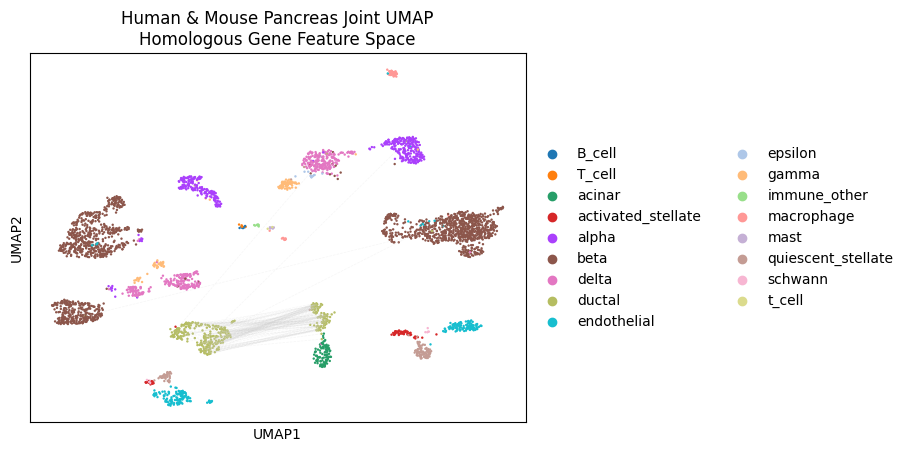

In [18]:
cell_type_label = "ductal"
plot_joint_umap_with_pairs(
    human_mouse_joint_adata=human_mouse_adata, 
    num_human_cells=human_restricted.shape[0], 
    paired_indices=paired_indices,
    color_label="species_label",  # species_label, cell_types
    save_path=f"/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_homolog_intersected_data/human_mouse_joint_umap_with_ot_pair_paths_color_species_{cell_type_label}_{human_to_mouse_str}.png",
    cell_type=cell_type_label,
    adata_human=human_restricted,
    adata_mouse=mouse_restricted,
    filter_by_human=human_to_mouse
)
plot_joint_umap_with_pairs(
    human_mouse_joint_adata=human_mouse_adata, 
    num_human_cells=human_restricted.shape[0], 
    paired_indices=paired_indices,
    color_label="cell_types",  # species_label, cell_types
    save_path=f"/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_homolog_intersected_data/human_mouse_joint_umap_with_ot_pair_paths_color_cell_type_{cell_type_label}_{human_to_mouse_str}.png",
    cell_type=cell_type_label,
    adata_human=human_restricted,
    adata_mouse=mouse_restricted,
    filter_by_human=human_to_mouse
)

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


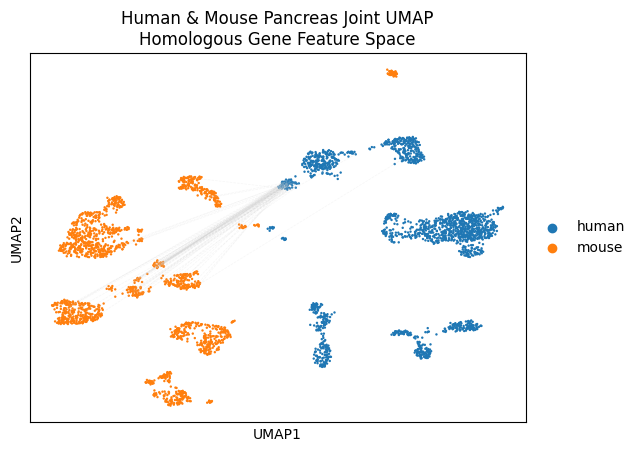

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


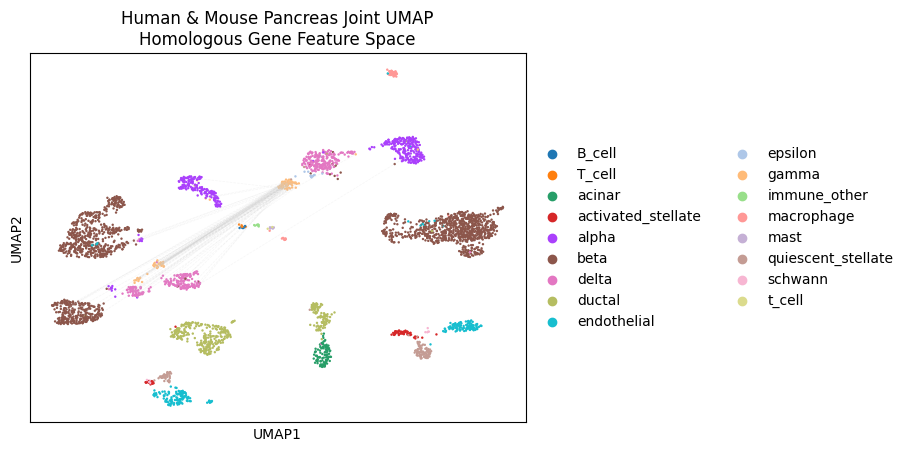

In [19]:
cell_type_label = "gamma"
plot_joint_umap_with_pairs(
    human_mouse_joint_adata=human_mouse_adata, 
    num_human_cells=human_restricted.shape[0], 
    paired_indices=paired_indices,
    color_label="species_label",  # species_label, cell_types
    save_path=f"/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_homolog_intersected_data/human_mouse_joint_umap_with_ot_pair_paths_color_species_{cell_type_label}_{human_to_mouse_str}.png",
    cell_type=cell_type_label,
    adata_human=human_restricted,
    adata_mouse=mouse_restricted,
    filter_by_human=human_to_mouse
)
plot_joint_umap_with_pairs(
    human_mouse_joint_adata=human_mouse_adata, 
    num_human_cells=human_restricted.shape[0], 
    paired_indices=paired_indices,
    color_label="cell_types",  # species_label, cell_types
    save_path=f"/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_homolog_intersected_data/human_mouse_joint_umap_with_ot_pair_paths_color_cell_type_{cell_type_label}_{human_to_mouse_str}.png",
    cell_type=cell_type_label,
    adata_human=human_restricted,
    adata_mouse=mouse_restricted,
    filter_by_human=human_to_mouse
)

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


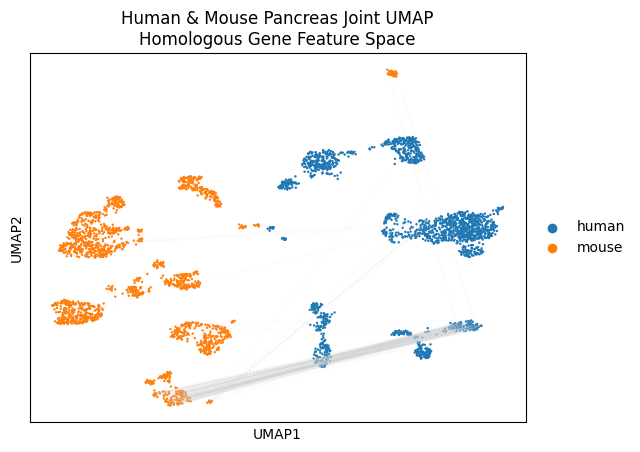

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


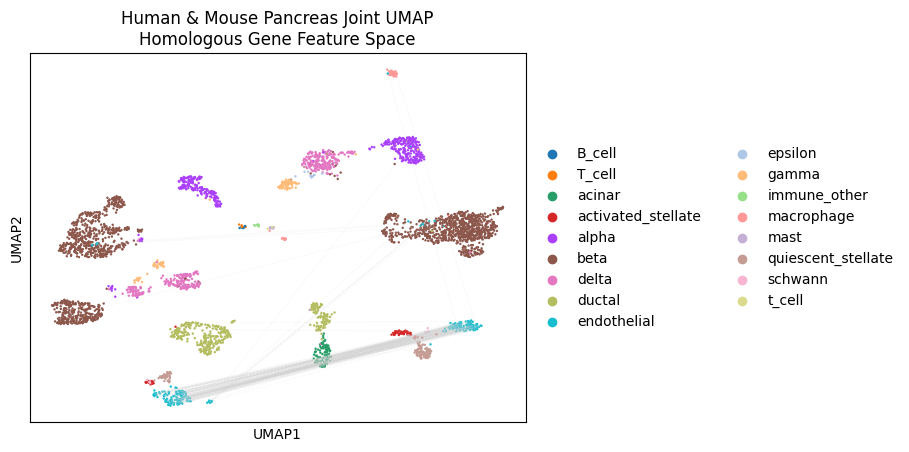

In [20]:
cell_type_label = "endothelial"
plot_joint_umap_with_pairs(
    human_mouse_joint_adata=human_mouse_adata, 
    num_human_cells=human_restricted.shape[0], 
    paired_indices=paired_indices,
    color_label="species_label",  # species_label, cell_types
    save_path=f"/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_homolog_intersected_data/human_mouse_joint_umap_with_ot_pair_paths_color_species_{cell_type_label}_{human_to_mouse_str}.png",
    cell_type=cell_type_label,
    adata_human=human_restricted,
    adata_mouse=mouse_restricted,
    filter_by_human=human_to_mouse
)
plot_joint_umap_with_pairs(
    human_mouse_joint_adata=human_mouse_adata, 
    num_human_cells=human_restricted.shape[0], 
    paired_indices=paired_indices,
    color_label="cell_types",  # species_label, cell_types
    save_path=f"/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_homolog_intersected_data/human_mouse_joint_umap_with_ot_pair_paths_color_cell_type_{cell_type_label}_{human_to_mouse_str}.png",
    cell_type=cell_type_label,
    adata_human=human_restricted,
    adata_mouse=mouse_restricted,
    filter_by_human=human_to_mouse
)

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


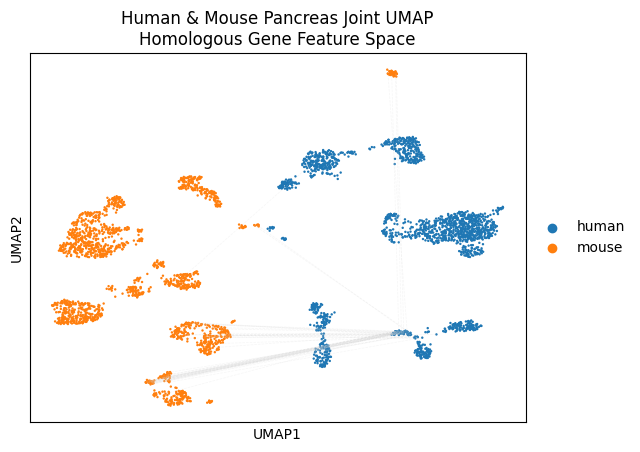

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


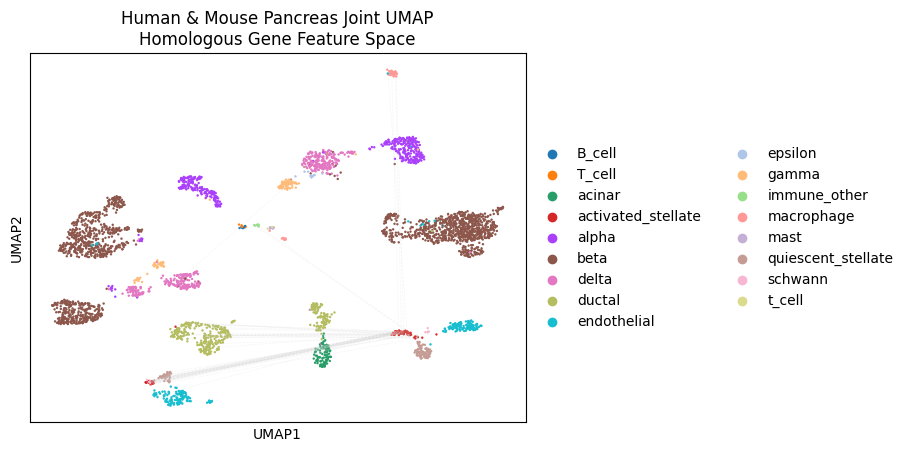

In [21]:
cell_type_label = "activated_stellate"
plot_joint_umap_with_pairs(
    human_mouse_joint_adata=human_mouse_adata, 
    num_human_cells=human_restricted.shape[0], 
    paired_indices=paired_indices,
    color_label="species_label",  # species_label, cell_types
    save_path=f"/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_homolog_intersected_data/human_mouse_joint_umap_with_ot_pair_paths_color_species_{cell_type_label}_{human_to_mouse_str}.png",
    cell_type=cell_type_label,
    adata_human=human_restricted,
    adata_mouse=mouse_restricted,
    filter_by_human=human_to_mouse
)
plot_joint_umap_with_pairs(
    human_mouse_joint_adata=human_mouse_adata, 
    num_human_cells=human_restricted.shape[0], 
    paired_indices=paired_indices,
    color_label="cell_types",  # species_label, cell_types
    save_path=f"/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_homolog_intersected_data/human_mouse_joint_umap_with_ot_pair_paths_color_cell_type_{cell_type_label}_{human_to_mouse_str}.png",
    cell_type=cell_type_label,
    adata_human=human_restricted,
    adata_mouse=mouse_restricted,
    filter_by_human=human_to_mouse
)

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


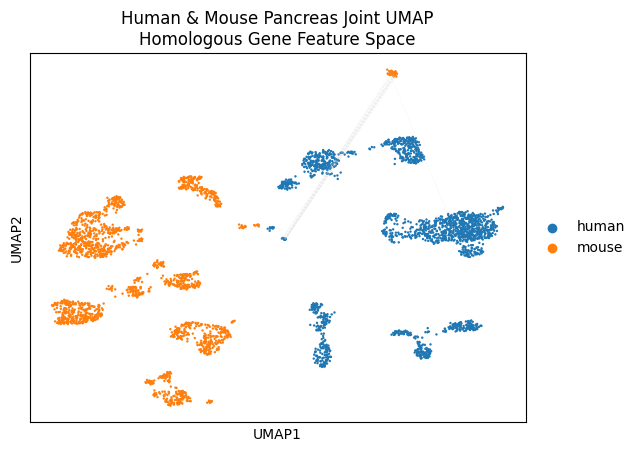

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


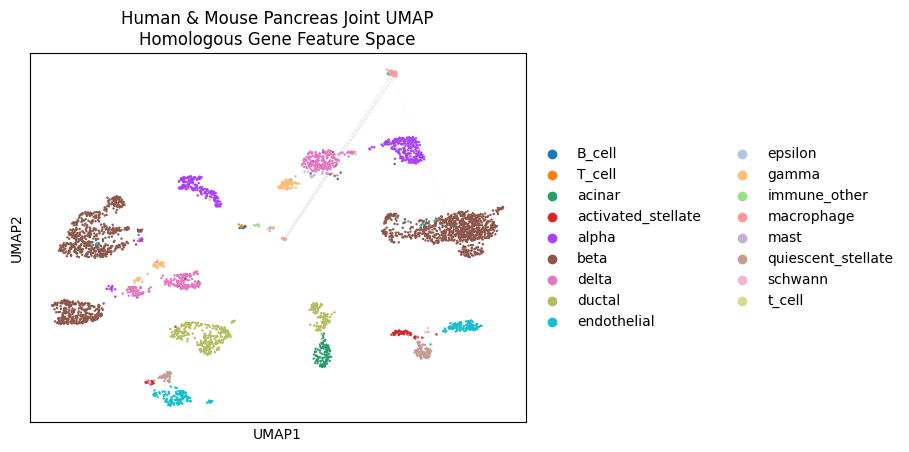

In [22]:
cell_type_label = "macrophage"
plot_joint_umap_with_pairs(
    human_mouse_joint_adata=human_mouse_adata, 
    num_human_cells=human_restricted.shape[0], 
    paired_indices=paired_indices,
    color_label="species_label",  # species_label, cell_types
    save_path=f"/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_homolog_intersected_data/human_mouse_joint_umap_with_ot_pair_paths_color_species_{cell_type_label}_{human_to_mouse_str}.png",
    cell_type=cell_type_label,
    adata_human=human_restricted,
    adata_mouse=mouse_restricted,
    filter_by_human=human_to_mouse
)
plot_joint_umap_with_pairs(
    human_mouse_joint_adata=human_mouse_adata, 
    num_human_cells=human_restricted.shape[0], 
    paired_indices=paired_indices,
    color_label="cell_types",  # species_label, cell_types
    save_path=f"/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_homolog_intersected_data/human_mouse_joint_umap_with_ot_pair_paths_color_cell_type_{cell_type_label}_{human_to_mouse_str}.png",
    cell_type=cell_type_label,
    adata_human=human_restricted,
    adata_mouse=mouse_restricted,
    filter_by_human=human_to_mouse
)

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


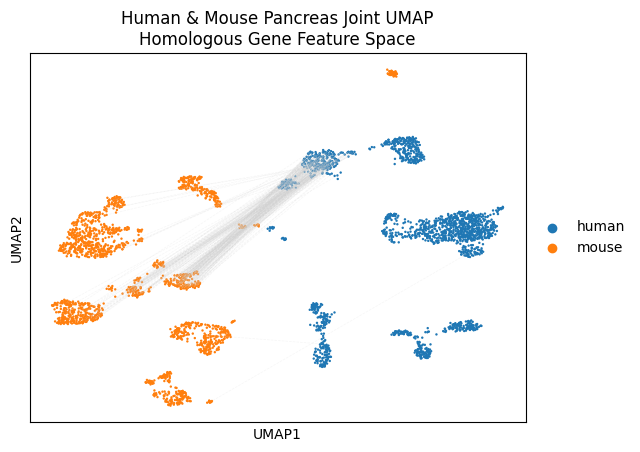

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


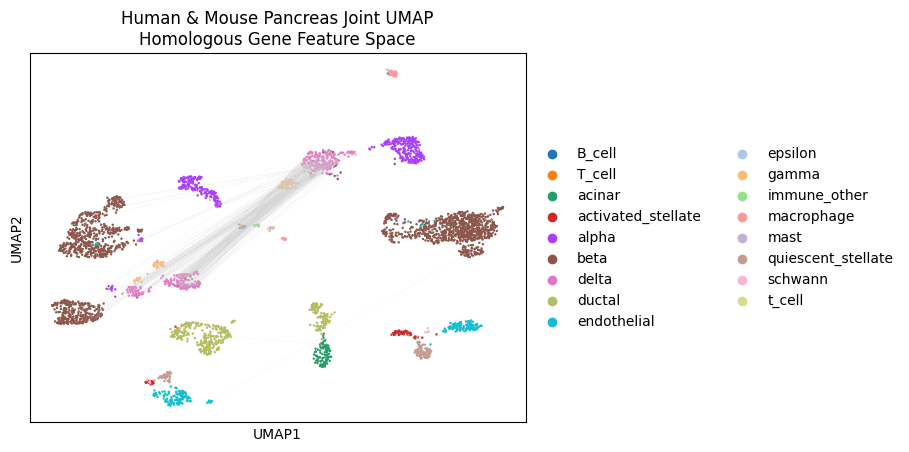

In [23]:
cell_type_label = "delta"
plot_joint_umap_with_pairs(
    human_mouse_joint_adata=human_mouse_adata, 
    num_human_cells=human_restricted.shape[0], 
    paired_indices=paired_indices,
    color_label="species_label",  # species_label, cell_types
    save_path=f"/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_homolog_intersected_data/human_mouse_joint_umap_with_ot_pair_paths_color_species_{cell_type_label}_{human_to_mouse_str}.png",
    cell_type=cell_type_label,
    adata_human=human_restricted,
    adata_mouse=mouse_restricted,
    filter_by_human=human_to_mouse
)
plot_joint_umap_with_pairs(
    human_mouse_joint_adata=human_mouse_adata, 
    num_human_cells=human_restricted.shape[0], 
    paired_indices=paired_indices,
    color_label="cell_types",  # species_label, cell_types
    save_path=f"/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_homolog_intersected_data/human_mouse_joint_umap_with_ot_pair_paths_color_cell_type_{cell_type_label}_{human_to_mouse_str}.png",
    cell_type=cell_type_label,
    adata_human=human_restricted,
    adata_mouse=mouse_restricted,
    filter_by_human=human_to_mouse
)

In [24]:
list(set(human_mouse_adata.obs["cell_types"]))

['immune_other',
 'acinar',
 'ductal',
 'delta',
 'quiescent_stellate',
 'T_cell',
 'beta',
 't_cell',
 'alpha',
 'macrophage',
 'schwann',
 'epsilon',
 'activated_stellate',
 'mast',
 'gamma',
 'B_cell',
 'endothelial']

In [25]:
plot_cell_types = [
    't_cell',
    'B_cell',
    'acinar',
    'epsilon',
    'T_cell',
    'mast',
    'schwann',
    'immune_other',
    'quiescent_stellate'
]

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


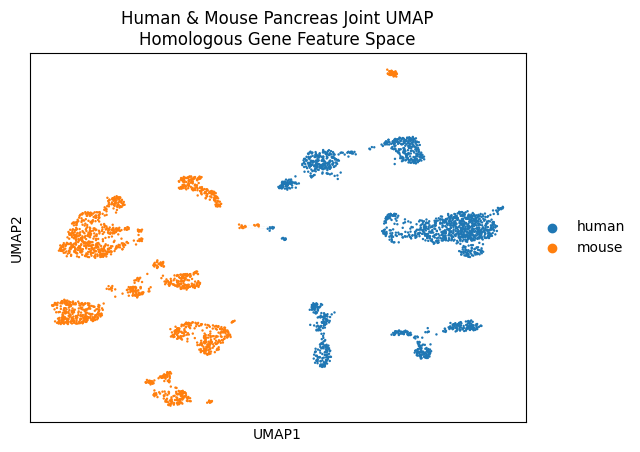

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


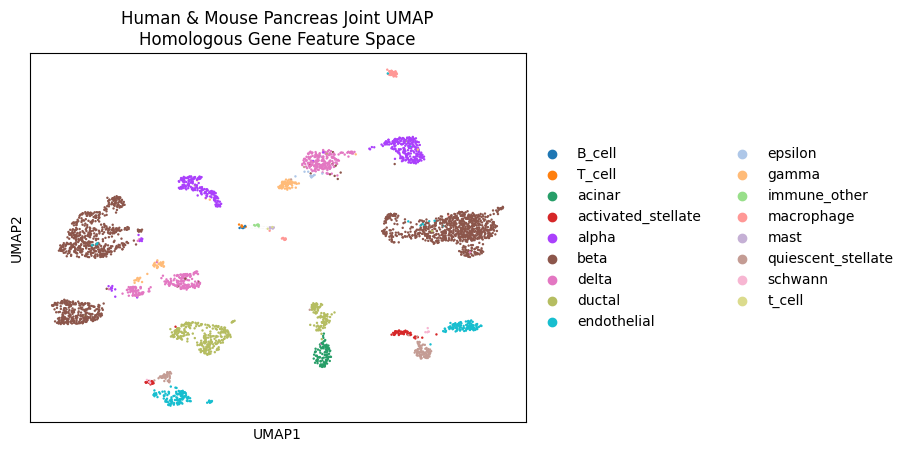

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


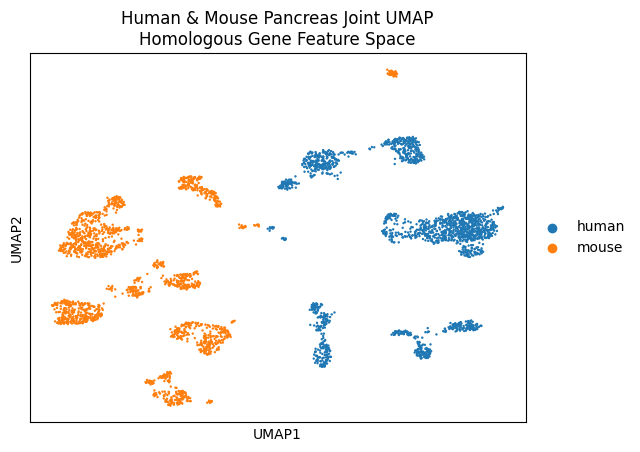

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


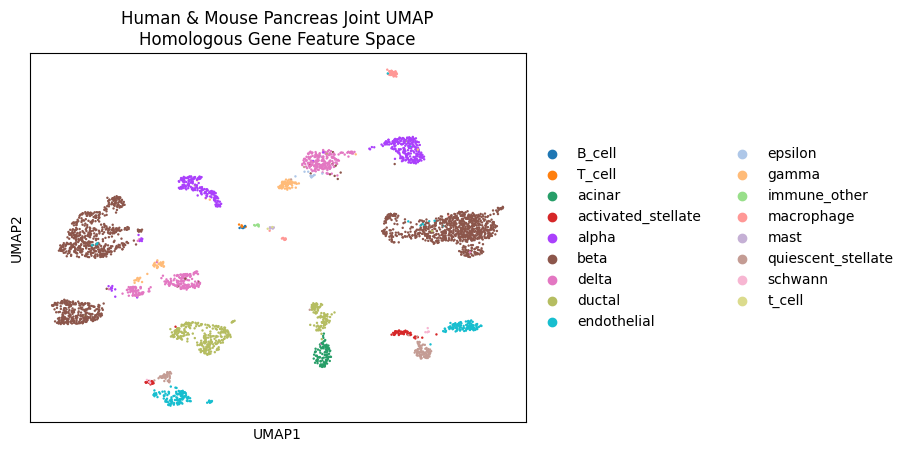

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


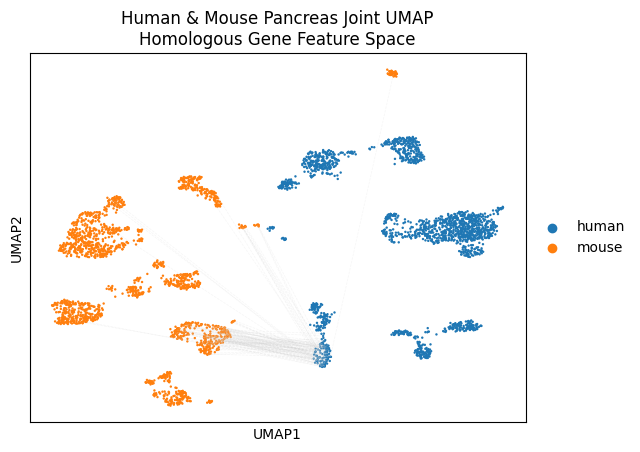

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


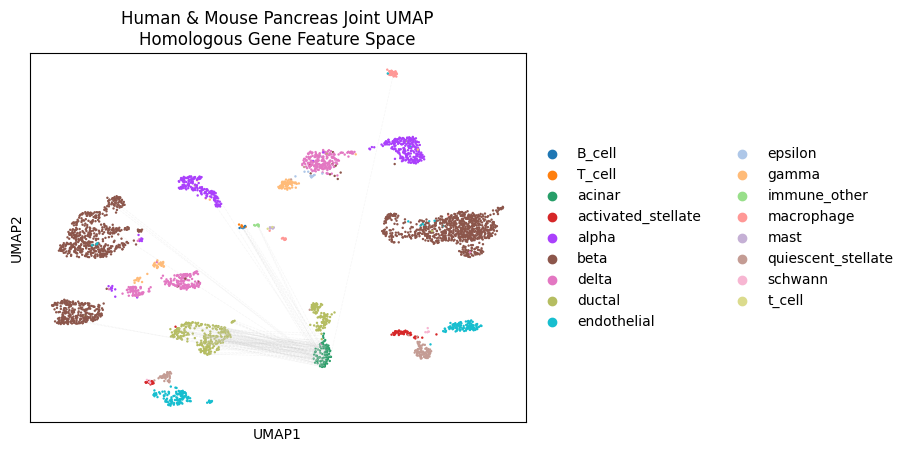

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


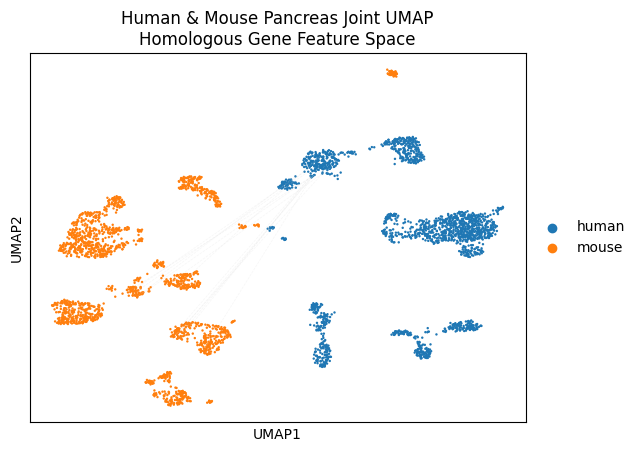

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


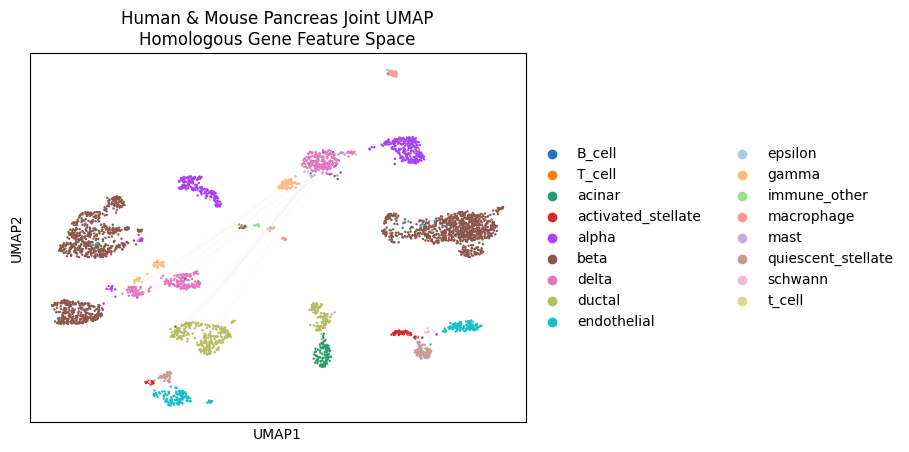

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


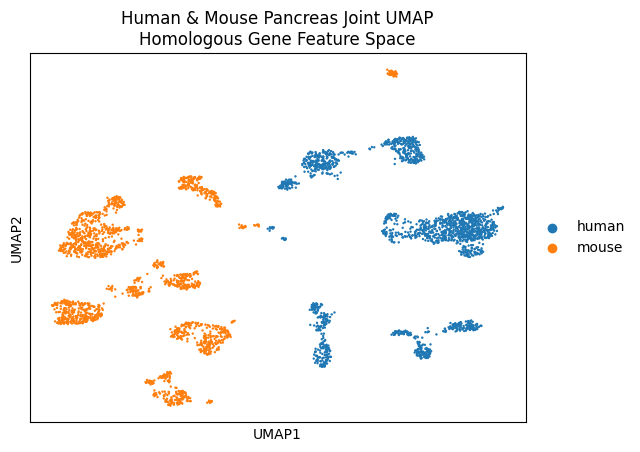

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


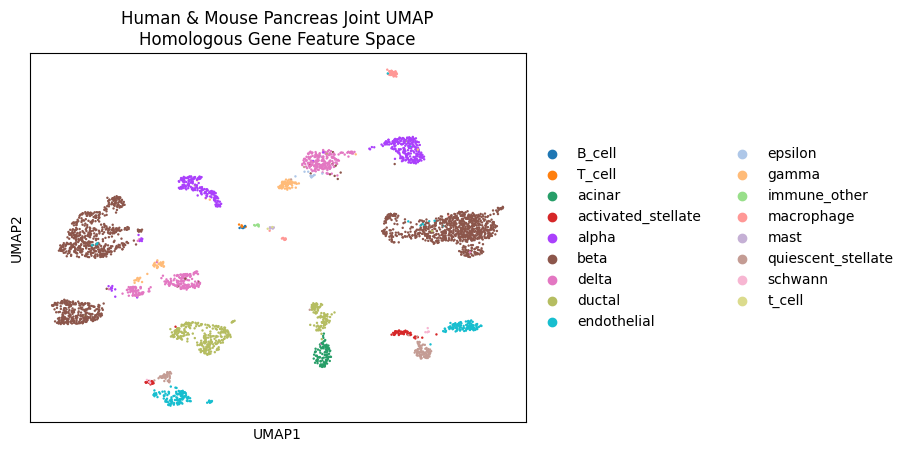

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


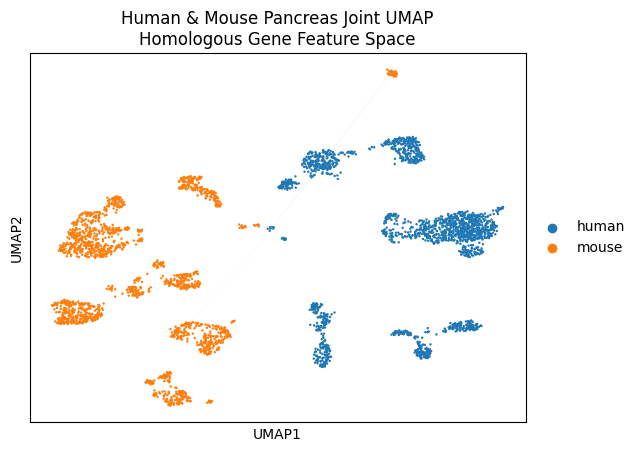

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


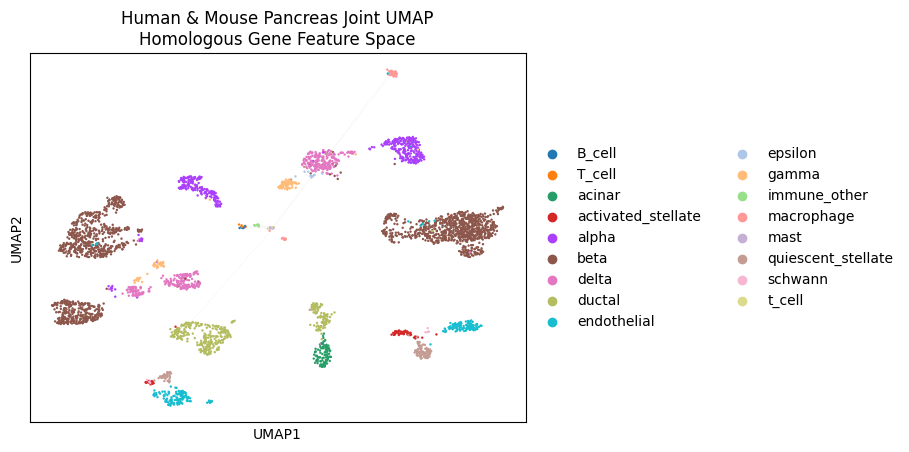

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


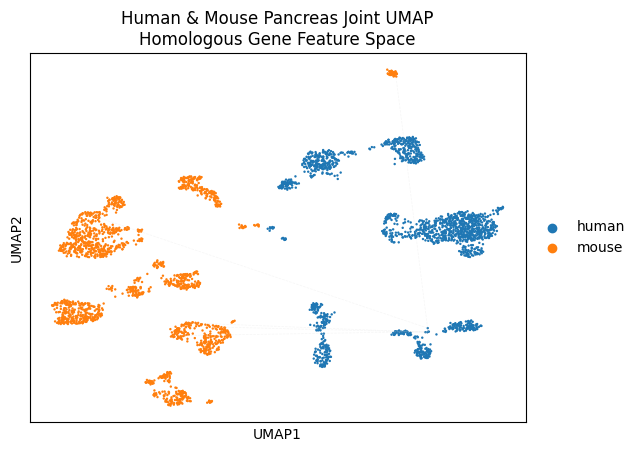

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


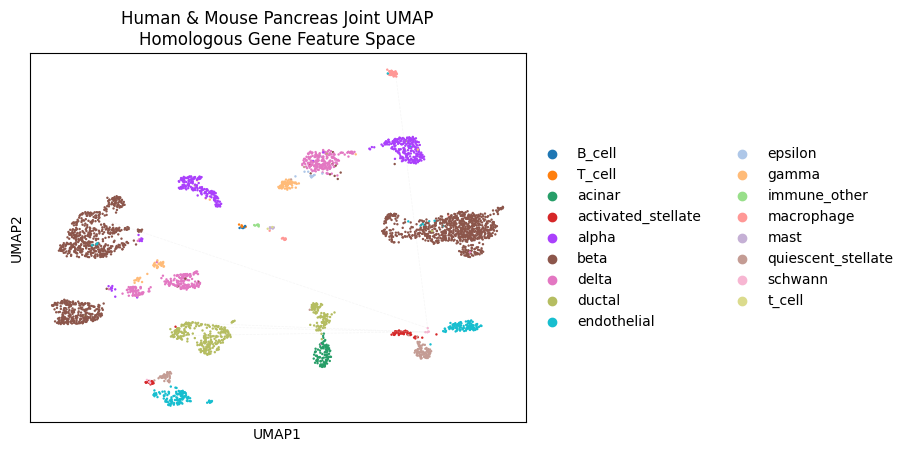

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


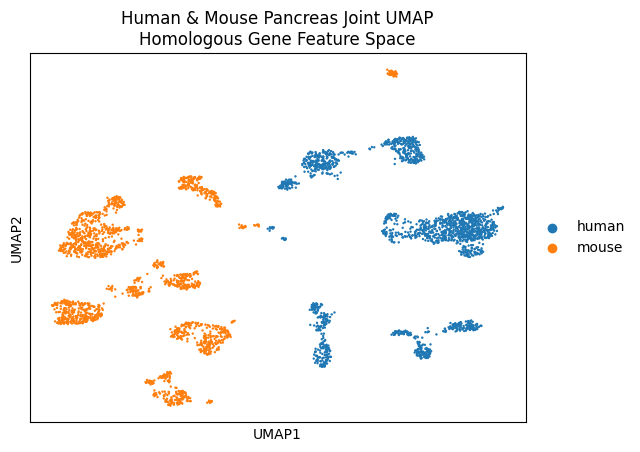

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


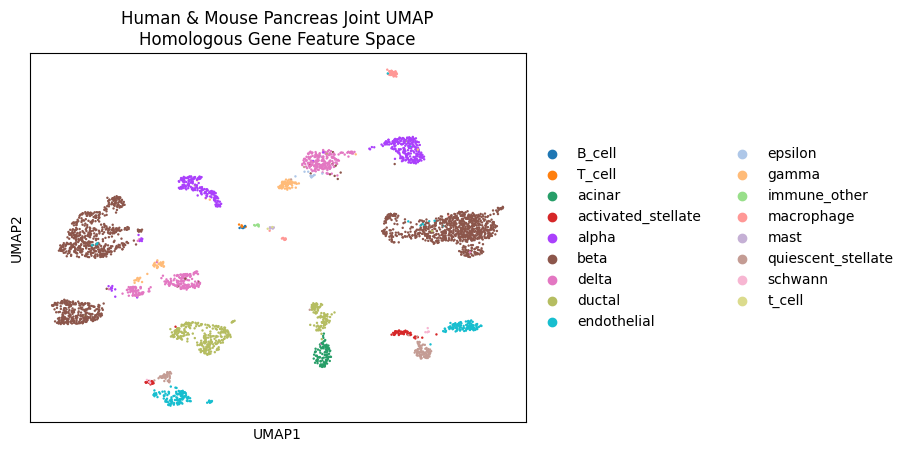

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


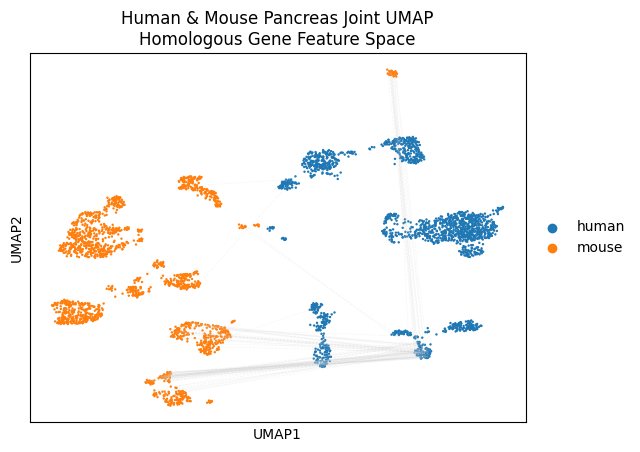

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


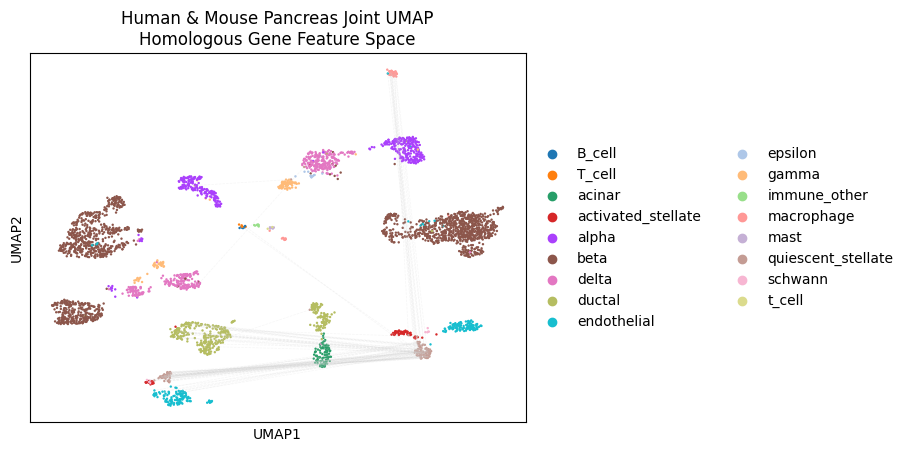

In [26]:
for cell_type_label in plot_cell_types:
    plot_joint_umap_with_pairs(
        human_mouse_joint_adata=human_mouse_adata, 
        num_human_cells=human_restricted.shape[0], 
        paired_indices=paired_indices,
        color_label="species_label",  # species_label, cell_types
        save_path=f"/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_homolog_intersected_data/human_mouse_joint_umap_with_ot_pair_paths_color_species_{cell_type_label}_{human_to_mouse_str}.png",
        cell_type=cell_type_label,
        adata_human=human_restricted,
        adata_mouse=mouse_restricted,
        filter_by_human=human_to_mouse
    )
    plot_joint_umap_with_pairs(
        human_mouse_joint_adata=human_mouse_adata, 
        num_human_cells=human_restricted.shape[0], 
        paired_indices=paired_indices,
        color_label="cell_types",  # species_label, cell_types
        save_path=f"/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_homolog_intersected_data/human_mouse_joint_umap_with_ot_pair_paths_color_cell_type_{cell_type_label}_{human_to_mouse_str}.png",
        cell_type=cell_type_label,
        adata_human=human_restricted,
        adata_mouse=mouse_restricted,
        filter_by_human=human_to_mouse
    )